# IMAGE CLASSIFIER

In [2]:
#import all modules and packages
%tensorflow_version 1.0
import math
import random
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage, misc
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.datasets import cifar10
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
#load cifar10 dataset
(X_train_orig,Y_train_orig),(X_test_orig,Y_test_orig)=cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


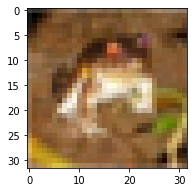

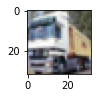

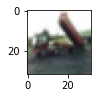

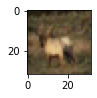

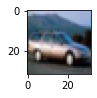

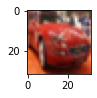

In [4]:
#plot some images from train set
n=6
plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(330+1+i)
    plt.imshow(X_train_orig[i])
    plt.show()

In [5]:
#convert pixel values to float and normalize input
X_train=X_train_orig.astype('float32')
X_test=X_test_orig.astype('float32')
X_train=X_train/255.0
X_test=X_test/255.0

In [6]:
def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [7]:
Y_train = one_hot_encode(Y_train_orig)
Y_test = one_hot_encode(Y_test_orig)
conv_layers = {}

In [8]:
#Creates the placeholders for the tensorflow session.
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes """

    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0], name = 'X')
    Y = tf.placeholder(tf.float32, [None, n_y], name = 'Y')
    
    return X, Y

In [9]:
# initialize_parameters: Use xavier_initializer

def initialize_parameters():
  
    W1 = tf.get_variable("W1", [3, 3, 3, 32], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [3, 3, 32, 32], initializer = tf.contrib.layers.xavier_initializer())
    W3 = tf.get_variable("W3", [3, 3, 32, 64], initializer = tf.contrib.layers.xavier_initializer())
    W4 = tf.get_variable("W4", [3, 3, 64, 64], initializer = tf.contrib.layers.xavier_initializer())
    W5 = tf.get_variable("W5", [3, 3, 64, 128], initializer = tf.contrib.layers.xavier_initializer())
    W6 = tf.get_variable("W6", [3, 3, 128, 128], initializer = tf.contrib.layers.xavier_initializer())
    W7 = tf.get_variable("W7", [3, 3, 128, 128], initializer = tf.contrib.layers.xavier_initializer())
    W8 = tf.get_variable("W8", [3, 3, 128, 256], initializer = tf.contrib.layers.xavier_initializer())

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4,
                  "W5": W5,
                  "W6": W6,
                  "W7": W7,
                  "W8": W8}
    
    return parameters

In [14]:
# forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> CONV2D -> MAXPOOL -> CONV2D ->CONV2D-> Maxpool->CONV2D ->CONV2D-> MAXPOOL ->CONV2D ->CONV2D-> MAXPOOL -> FLATTEN -> FULLYCONNECTED->RELU->FC -> softmax
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    W6 = parameters['W6']
    W7 = parameters['W7']
    W8 = parameters['W8']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)

    A1_norm = tf.compat.v1.layers.batch_normalization(A1, axis=-1, momentum=0.99, epsilon=0.001)

    # CONV2D: stride of 1, padding 'SAME'
    Z2 = tf.nn.conv2d(A1_norm, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    A2_norm = tf.compat.v1.layers.batch_normalization(A2, axis=-1, momentum=0.99, epsilon=0.001)

    # MAXPOOL: window 2x2, stride 2, padding 'SAME'
    P1 = tf.nn.max_pool(A2_norm, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    drop_P1 = tf.nn.dropout(P1, rate = 0.2, noise_shape=None, seed=None, name=None)

    # CONV2D:stride 1, padding 'SAME'
    Z3 = tf.nn.conv2d(drop_P1,W3, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    # batch normalisation
    A3_norm = tf.compat.v1.layers.batch_normalization(A3, axis=-1, momentum=0.99, epsilon=0.001)

    # CONV2D: stride 1, padding 'SAME'
    Z4 = tf.nn.conv2d(A3_norm, W4, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A4 = tf.nn.relu(Z4)
    # batch normalisation
    A4_norm = tf.compat.v1.layers.batch_normalization(A4, axis=-1, momentum=0.99, epsilon=0.001)

    # MAXPOOL: window 2x2, stride 2, padding 'SAME'
    P2 = tf.nn.max_pool(A4_norm, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # dropout
    drop_P2 = tf.nn.dropout(P2, rate = 0.3, noise_shape=None, seed=None, name=None)

    # CONV2D: stride 1, padding 'SAME'
    Z5 = tf.nn.conv2d(drop_P2, W5, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A5 = tf.nn.relu(Z5)
    # batch normalisation
    A5_norm = tf.compat.v1.layers.batch_normalization(A5, axis=-1, momentum=0.99, epsilon=0.001)

    # CONV2D: stride 1, padding 'SAME'
    Z6 = tf.nn.conv2d(A5_norm, W6, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A6 = tf.nn.relu(Z6)
    # batch normalisation
    A6_norm = tf.compat.v1.layers.batch_normalization(A6, axis=-1, momentum=0.99, epsilon=0.001)

    # MAXPOOL: window 2x2, stride 2, padding 'SAME'
    P3 = tf.nn.max_pool(A6_norm, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    # dropout
    drop_P3 = tf.nn.dropout(P3, rate = 0.4, noise_shape=None, seed=None, name=None)
    
    # CONV2D: stride 1, padding 'SAME'
    Z7 = tf.nn.conv2d(drop_P3, W7, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A7 = tf.nn.relu(Z7)
    # batch normalisation
    A7_norm = tf.compat.v1.layers.batch_normalization(A7, axis=-1, momentum=0.99, epsilon=0.001)

    # CONV2D: stride 1, padding 'SAME'
    Z8 = tf.nn.conv2d(A7_norm, W8, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A8 = tf.nn.relu(Z8)
    # batch normalisation
    A8_norm = tf.compat.v1.layers.batch_normalization(A8, axis=-1, momentum=0.99, epsilon=0.001)

    # MAXPOOL: window 2x2, stride 2, padding 'SAME'
    P4 = tf.nn.max_pool(A8_norm, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    # dropout
    drop_P4 = tf.nn.dropout(P4, rate = 0.5, noise_shape=None, seed=None, name=None)

    # FLATTEN
    F = tf.contrib.layers.flatten(drop_P4)
    # FULLY-CONNECTED with relu activation function 
    A9 = tf.contrib.layers.fully_connected(F, 128, activation_fn=tf.nn.relu)
    
    # batch normalisation
    A9_norm = tf.compat.v1.layers.batch_normalization(A9, axis=-1, momentum=0.99, epsilon=0.001)
    
    # dropout
    drop_A9 = tf.nn.dropout(A9_norm, rate = 0.5, noise_shape=None, seed=None, name=None)
    
    # FC
    Z10 = tf.contrib.layers.fully_connected(drop_A9, 10, activation_fn = None)

    return Z10

In [15]:
# compute_cost 

def compute_cost(Z, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    
    return cost

In [16]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 32, print_cost = True):
    
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    #seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
           
            for i in range(num_minibatches):
                # Select a minibatch
                a = random.randrange(num_minibatches)
  
                minibatch_X, minibatch_Y = (X_train[minibatch_size*a:minibatch_size*(a+1)], Y_train[minibatch_size*a:minibatch_size*(a + 1)])
               
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every 5 epochs
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z, 1)
        given_op = tf.argmax(Y, 1)
        correct_prediction = tf.equal(given_op, predict_op)

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train[:10000], Y: Y_train[:10000]})
        test_accuracy = accuracy.eval({X: X_test[:10000], Y: Y_test[:10000]})
        print("Train Accuracy: ", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.863191
Cost after epoch 5: 0.907195
Cost after epoch 10: 0.674389
Cost after epoch 15: 0.560958
Cost after epoch 20: 0.477994
Cost after epoch 25: 0.419867
Cost after epoch 30: 0.371566
Cost after epoch 35: 0.334123
Cost after epoch 40: 0.302258
Cost after epoch 45: 0.281272
Cost after epoch 50: 0.263376
Cost after epoch 55: 0.242304
Cost after epoch 60: 0.234722
Cost after epoch 65: 0.214463
Cost after epoch 70: 0.198589
Cost after epoch 75: 0.190348
Cost after epoch 80: 0.183613
Cost after epoch 85: 0.178441
Cost after epoch 90: 0.170148
Cost after epoch 95: 0.160700


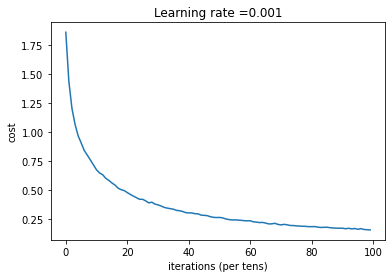

Train Accuracy:  0.9501
Test Accuracy: 0.8252


In [17]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)